# PokeGAN

Simple GAN trained on all the pokemon sprite images. No transfer learning is used and the only input to the generator is the random vector.

In [21]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [22]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))

In [23]:
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as torch_data
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src import utils
from src.gan import generators, discriminators

### Load Dataset

In [24]:
image_root_dir = "../data/images/"
color=False
image_data, filenames = utils.load_images(image_root_dir, color)

Total number of files: 857


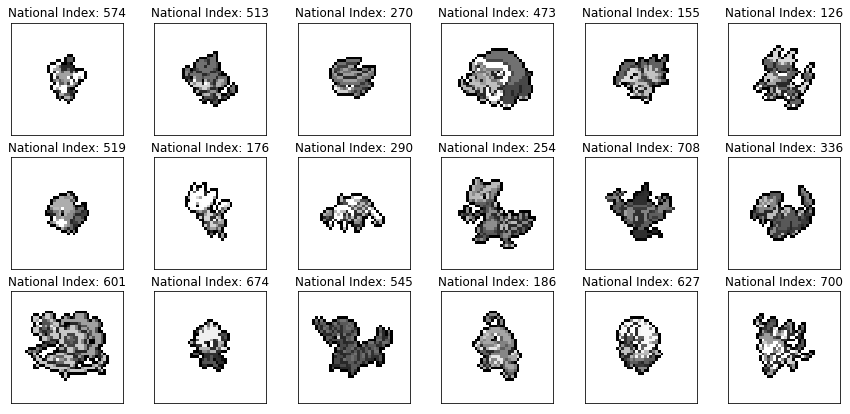

In [25]:
sample = np.random.choice(len(image_data), size=18, replace=False)
fig = plt.figure(figsize=(15, 7))
for i, img_index in enumerate(sample):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    if color:
        ax.imshow(image_data[img_index])
    else:
        ax.imshow(image_data[img_index], cmap='gray')
    ax.set_title(f"National Index: {filenames[img_index][:3]}")

### Datasets & DataLoaders

In [51]:
data = torch.from_numpy(image_data)
data = data.unsqueeze(dim=1)

In [52]:
data.size(), data.dtype

(torch.Size([857, 1, 40, 40]), torch.float32)

In [54]:
training_dataset = torch_data.TensorDataset(data)
training_dataloader = torch_data.DataLoader(training_dataset, batch_size=16, shuffle=True)

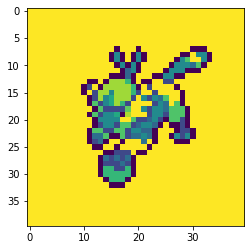

In [56]:
dataset_sample = next(iter(training_dataloader))[0][0]
plt.imshow(dataset_sample.squeeze())

## Networks

In [88]:
img_size = 40

# Generator
noise_size = 200

### Discriminator

In [89]:
D = discriminators.DCDiscriminator(is_greyscale=True)
D

DCDiscriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=3200, out_features=1, bias=True)
)

### Generator

In [90]:
G = generators.DCGenerator(noise_size, is_greyscale=True)
G

DCGenerator(
  (fc): Linear(in_features=200, out_features=3200, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [91]:
def scale(x, features=(-1, 1)):
    min_x, max_x = features
    return x * (max_x - min_x) + min_x

### Losses

In [96]:
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    labels = torch.ones_like(D_out)
    labels = labels * 0.9 if smooth else labels 
    
    loss_criterion = nn.BCEWithLogitsLoss()
    
    loss = loss_criterion(D_out, labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    labels = torch.zeros_like(D_out)
    
    loss_criterion = nn.BCEWithLogitsLoss()
    loss = loss_criterion(D_out, labels)
    return loss

### Optimisers

In [94]:
# learning rate for optimizers
lr_d = 0.001
lr_g = 0.001

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))

## Training

In [97]:
# training hyperparams
num_epochs = 200

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = utils.generate_random((sample_size, noise_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, real_images in enumerate(training_dataloader):
                
        real_images = real_images[0]
        batch_size = real_images.size(0)
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        # 1. Train with real images
        d_optimizer.zero_grad()
        
        # Compute the discriminator losses on real images
        # use smoothed labels
        batch_out_real = D.forward(real_images)
        d_real_loss = real_loss(batch_out_real, smooth=True)
        
        # 2. Train with fake images
        # Generate fake images
        z = utils.generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        
        # add up real and fake losses and perform backprop
        batch_out_fake = D.forward(fake_images)
        d_fake_loss = fake_loss(batch_out_fake)
    
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        
        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = utils.generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        
        # perform backprop
        gen_out_fake = D(fake_images)
        g_loss = real_loss(gen_out_fake)
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  200] | d_loss: 1.3319 | g_loss: 0.9770
Epoch [    2/  200] | d_loss: 0.8829 | g_loss: 1.5305
Epoch [    3/  200] | d_loss: 0.5685 | g_loss: 2.5675
Epoch [    4/  200] | d_loss: 0.7902 | g_loss: 2.0152
Epoch [    5/  200] | d_loss: 0.4643 | g_loss: 3.1027
Epoch [    6/  200] | d_loss: 1.0059 | g_loss: 1.8042
Epoch [    7/  200] | d_loss: 1.1107 | g_loss: 0.9834
Epoch [    8/  200] | d_loss: 0.7125 | g_loss: 3.4280
Epoch [    9/  200] | d_loss: 0.5719 | g_loss: 2.9950
Epoch [   10/  200] | d_loss: 0.5187 | g_loss: 4.6582
Epoch [   11/  200] | d_loss: 0.8941 | g_loss: 4.1474
Epoch [   12/  200] | d_loss: 0.7392 | g_loss: 3.3768
Epoch [   13/  200] | d_loss: 0.5047 | g_loss: 3.8270
Epoch [   14/  200] | d_loss: 0.6067 | g_loss: 4.0113
Epoch [   15/  200] | d_loss: 0.7625 | g_loss: 1.7962
Epoch [   16/  200] | d_loss: 0.5150 | g_loss: 3.1849
Epoch [   17/  200] | d_loss: 0.4550 | g_loss: 4.5387
Epoch [   18/  200] | d_loss: 0.5168 | g_loss: 2.8274
Epoch [   19/  200] | d_loss

Epoch [  153/  200] | d_loss: 0.3632 | g_loss: 5.5654
Epoch [  154/  200] | d_loss: 0.3579 | g_loss: 5.8783
Epoch [  155/  200] | d_loss: 0.3617 | g_loss: 6.3345
Epoch [  156/  200] | d_loss: 0.3597 | g_loss: 7.0984
Epoch [  157/  200] | d_loss: 0.3560 | g_loss: 6.2893
Epoch [  158/  200] | d_loss: 0.3431 | g_loss: 6.8734
Epoch [  159/  200] | d_loss: 0.3387 | g_loss: 5.8196
Epoch [  160/  200] | d_loss: 0.4280 | g_loss: 4.3659
Epoch [  161/  200] | d_loss: 0.4359 | g_loss: 4.3440
Epoch [  162/  200] | d_loss: 0.3635 | g_loss: 6.6990
Epoch [  163/  200] | d_loss: 0.3681 | g_loss: 5.5400
Epoch [  164/  200] | d_loss: 0.3619 | g_loss: 5.9744
Epoch [  165/  200] | d_loss: 0.3557 | g_loss: 5.9702
Epoch [  166/  200] | d_loss: 0.3343 | g_loss: 7.0275
Epoch [  167/  200] | d_loss: 0.3532 | g_loss: 5.8879
Epoch [  168/  200] | d_loss: 0.3972 | g_loss: 4.9213
Epoch [  169/  200] | d_loss: 0.3693 | g_loss: 5.5904
Epoch [  170/  200] | d_loss: 0.3444 | g_loss: 5.9558
Epoch [  171/  200] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

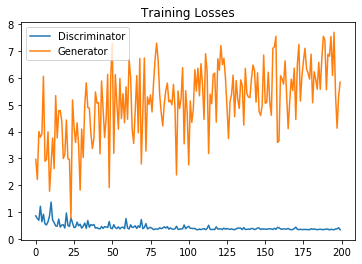

In [98]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Sampling

In [100]:
def reshape_sample(samples, img_size, is_rgb=True):
    samples = (samples + 1) / 2  # Reverse scaling
    if is_rgb:
        samples = samples.view(samples.size(0), img_size, img_size, 3)
    else:
        samples = samples.view(samples.size(0), img_size, img_size)
    samples.detach()
    return samples.numpy()

In [103]:
# randomly generated, new latent vectors
sample_size=16
rand_z = utils.generate_random((sample_size, noise_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
with torch.no_grad():
    rand_images = G(rand_z)

In [104]:
reshaped_images = reshape_sample(rand_images, img_size, is_rgb=color)

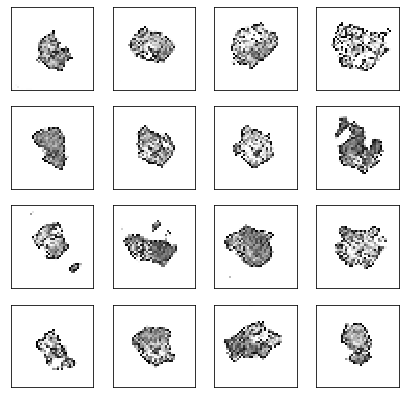

In [106]:
fig = plt.figure(figsize=(7, 7))
for i, s in enumerate(reshaped_images):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(s, cmap='gray')

### Load Training Samples

In [108]:
training_samples = pkl.load(open("train_samples.pkl", 'rb'))

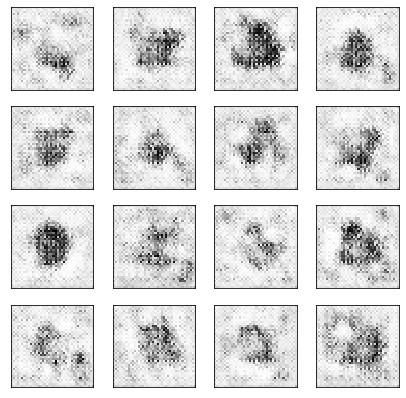

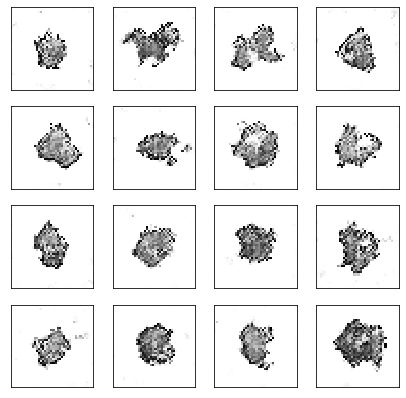

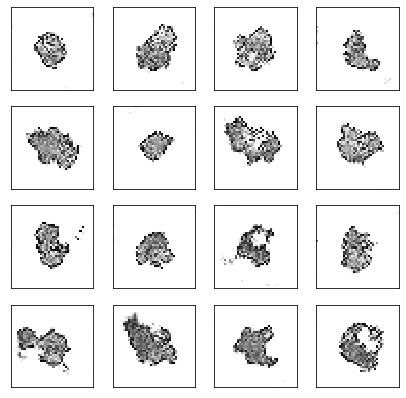

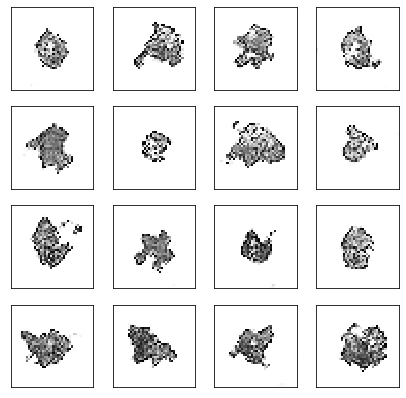

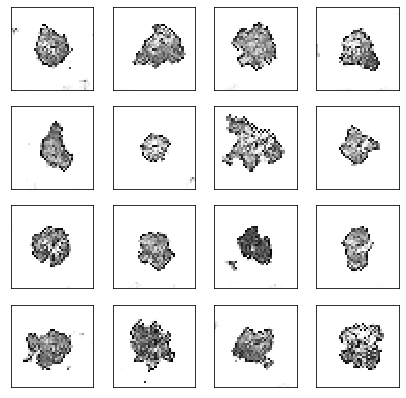

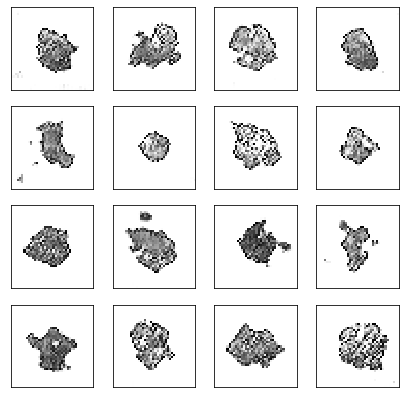

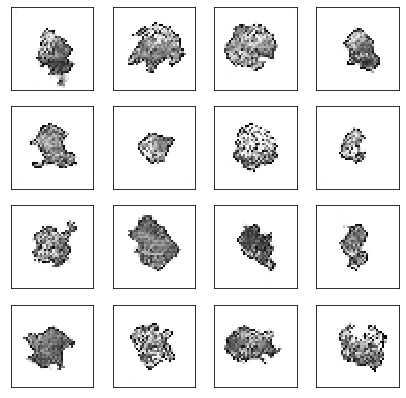

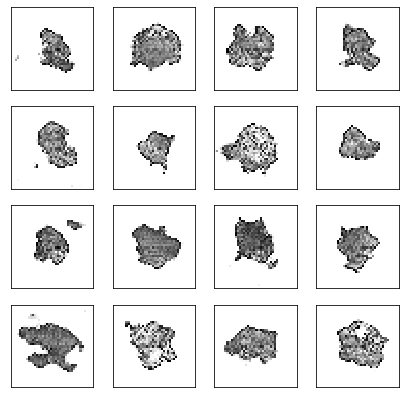

In [114]:
for i in range(0, len(training_samples), 25):
    reshaped_images = reshape_sample(training_samples[i].detach(), img_size, is_rgb=color)
    fig = plt.figure(figsize=(7, 7))
    for i, s in enumerate(reshaped_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(s, cmap='gray')